In [11]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import tensor
from torch import nn
import seaborn as sns
from torch.autograd.functional import jacobian
SAVEFIG = True

In [12]:
# Initializing matrix
num_nodes = 2000
np.random.seed(3)

connectivity_matrix = np.ones((num_nodes, num_nodes))
weight_matrix = np.random.normal(0, 1/np.sqrt(num_nodes), (num_nodes, num_nodes))
for i in range(num_nodes):
    weight_matrix[i, i] = 0
    connectivity_matrix[i, i] = 0
output_weight_matrix = np.random.uniform(-1, 1, (1, num_nodes))
feedback_weight_matrix = np.random.uniform(-1, 1, (num_nodes, 1)) # * 0.5
init_state = np.random.uniform(-0.5, 0.5, (num_nodes, 1))
init_gain = np.ones((num_nodes, 1))
init_shift = np.zeros((num_nodes, 1))

In [13]:
# Dale's Law
excite_perc = 0.5
excite_num = int(excite_perc*num_nodes)
node_type = np.array([1]*excite_num + [-1]*(num_nodes-excite_num))
weight_type = np.tile(node_type, num_nodes).reshape(num_nodes, -1)

# Enforce Dale's Law
weight_matrix = np.abs(weight_matrix) * weight_type
output_weight_matrix = np.abs(output_weight_matrix) * node_type

# normalize
ext_weight_sum = num_nodes/4
inh_weight_sum = num_nodes/4
tmp_output_weight_matrix = output_weight_matrix.copy()
tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
output_weight_matrix = tmp_output_weight_matrix.copy()
init_output_weight_matrix = output_weight_matrix.copy()

In [14]:
# define targets
time_points = np.arange(20000)
half_period = 20
# targets = (np.sin((time_points+1)/60*np.pi))/4 + 0.5
targets = ((np.sin((time_points + 10)/half_period*np.pi))/4 + 0.5)

# inputs with different phases and period
np.random.seed(3)
inputs = []
for i in range(num_nodes):
    this_half_period = np.random.randint(15, 25)
    # this_half_period = np.random.choice([10, 20, 30])
    this_input = (np.sin((time_points + np.random.randint(0, half_period*2))/this_half_period*np.pi))/4 + 0.5
    inputs.append(this_input)
inputs = np.array(inputs)

In [15]:
# define sigmoid
def sigmoid_np(x):
    return 1 / (1 + np.exp(-x))

def inv_sigmoid_np(x):
    return -np.log((1 / x) - 1)

Must use activation as x rather than state. Otherwise, the output would not be a linear readout and depend on u.

In [16]:
# imitate rnn_FORCE
class mysys():
    def __init__(self, weight_matrix, connectivity_matrix, gain, shift, input_weight_matrix=None, inputs=None):
        # core parameters
        self.weight_matrix = weight_matrix
        self.connectivity_matrix = connectivity_matrix
        self.gain = gain
        self.shift = shift
        self.inputs = inputs
        self.input_weight_matrix = input_weight_matrix
        self.activation_func = nn.Sigmoid()
        
        # transfer into tensor
        self.weight_matrix_tensor = tensor(self.weight_matrix)
        self.gain_tensor = tensor(self.gain)
        self.shift_tensor = tensor(self.shift)
        
        # constants
        self.time_const = 1
        self.timestep = 0.1
        self.c = self.timestep / self.time_const
        self.g = 1.5
        self.i = 0

    def f_tensor(self, x_tensor, u_tensor, r_tensor):
        # this_input_tensor = torch.matmul(tensor(self.input_weight_matrix), tensor([[self.inputs[self.i]]]))
        y_tensor = (1 - self.c) * x_tensor \
            + self.c * self.activation_func((self.gain_tensor + u_tensor) * (self.g * torch.matmul(self.weight_matrix_tensor, x_tensor) + r_tensor - self.shift_tensor))
        return y_tensor
     
    def f(self, x, u, r):
        x_tensor = tensor(x)
        u_tensor = tensor(u)
        r_tensor = tensor(r)
        y_tensor = self.f_tensor(x_tensor, u_tensor, r_tensor)
        y = y_tensor.numpy()
        return y
    
    def jacob(self, x, u, r):
        x_tensor = tensor(x)
        u_tensor = tensor(u)
        r_tensor = tensor(r)
        dydx, dydu, dydr = jacobian(self.f_tensor,(x_tensor, u_tensor, r_tensor))
        Jx_tensor = dydx.squeeze(dim=(1,3))
        Ju_tensor = dydu.squeeze(dim=(1,3))
        Jr_tensor = dydr.squeeze(dim=(1,3))
        Jx = Jx_tensor.numpy()
        Ju = Ju_tensor.numpy()
        Jr = Jr_tensor.numpy()
        return Jx, Ju, Jr

# jnn_ff = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift, input_weight_matrix=feedback_weight_matrix, inputs=targets)
# jnn = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift, input_weight_matrix=feedback_weight_matrix, inputs=targets)
jnn_ff = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift)
jnn = mysys(weight_matrix, connectivity_matrix, init_gain, init_shift)

### Simulate Without Control

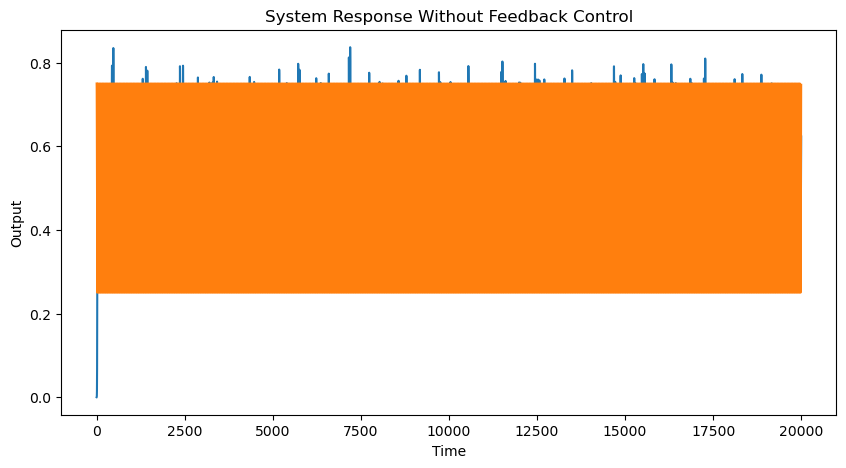

In [17]:
# Simulation Without Control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
u = init_state.copy() * 0
xs_ff_init, outputs_ff_init = [x], []
gainout= 1.15 # 1.15
shiftout= 5.5 # -2.5
out_lr = 0.002

for i in time_points[:-1]:
    
    # jnn_ff.i = i

    # output
    output_beforesig = output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # # adjust the gainout and shiftout
    # period = 2 * half_period
    # if i > period:
    #     mean_output = np.mean(outputs_ff_init[i-period:i])
    #     amplitude = np.max(outputs_ff_init[i-period:i]) - np.min(outputs_ff_init[i-period:i])
    #     if np.abs(mean_output - 0.5) > 0.01:
    #         shiftout += out_lr * np.sign(mean_output - 0.5)
    #     if np.abs(amplitude - 0.5) > 0.01:
    #         gainout -= out_lr * np.sign(amplitude - 0.5)

    # input
    this_input = inputs[:,i]
    r = feedback_weight_matrix * this_input.reshape(-1,1)

    # update x
    x1 = jnn_ff.f(x, u, r)
    x = x1.copy()
    
    # save
    xs_ff_init.append(x)
    outputs_ff_init.append(output.item())

# final readout for x_T
output_beforesig = output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_ff_init.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff_init)
plt.plot(time_points, targets)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

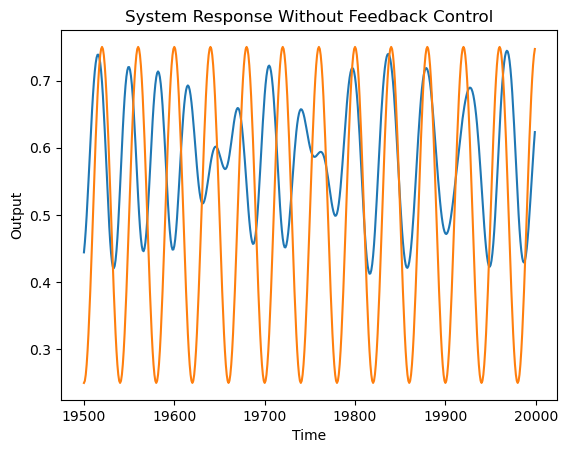

In [18]:
# plt.plot(time_points[0:500], outputs_ff_init[0:500])
# plt.plot(time_points[0:500], targets[0:500])
plt.plot(time_points[-500:], outputs_ff_init[-500:])
plt.plot(time_points[-500:], targets[-500:])
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
if SAVEFIG:
    plt.savefig("fig/FORCE_basis_ff_outputs_0605.png")

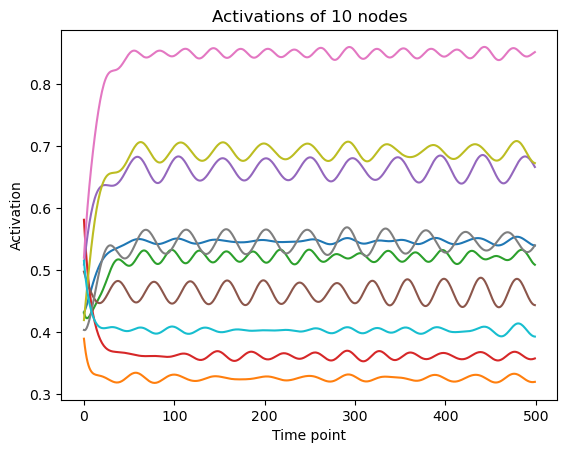

In [19]:
all_xs_ff_init = np.concatenate(xs_ff_init, axis=1)
for i in range(0, 10):
    plt.plot(all_xs_ff_init[i,0:500], label=f"Node {i}")
plt.xlabel("Time point")
plt.ylabel("Activation")
plt.title("Activations of 10 nodes")
if SAVEFIG:
    plt.savefig("fig/FORCE_basis_ff_activations_0605.png")

Definition of phase here: phase = 0 means peak at timepoint 0

Target now has phase = 0

In [102]:
# mean of each node
stable_point = 200
mean_activation = np.mean(all_xs_ff_init[:, stable_point:], axis=1)

In [103]:
periods = []
phases = []
for i in range(num_nodes):
    # for each node, find the time point when it reaches the local maximum
    peak_time = []
    for j in range(stable_point, len(time_points)-1):
        if all_xs_ff_init[i,j-1] < all_xs_ff_init[i,j] and all_xs_ff_init[i,j] > all_xs_ff_init[i,j+1]:
            peak_time.append(j)
    
    peak_time_diff = np.diff(peak_time)
    this_period = np.mean(peak_time_diff).round()
    this_phase = peak_time[0] % this_period

    periods.append(this_period)
    phases.append(this_phase)

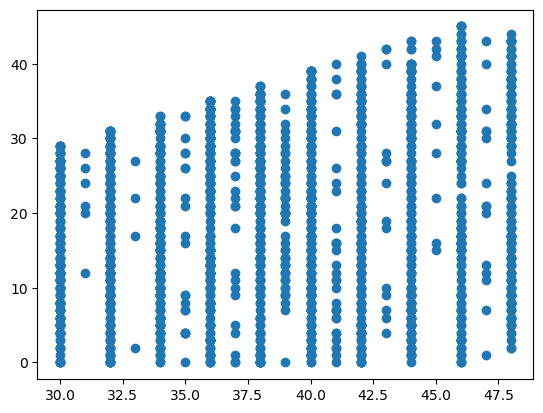

In [104]:
# plot the periods and phases
plt.scatter(periods, phases)

Text(0, 0.5, 'Output weight')

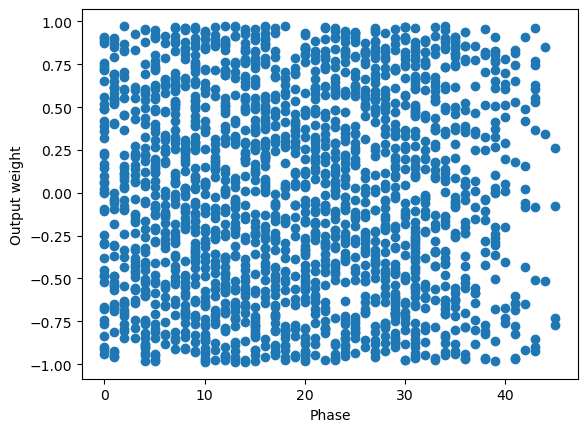

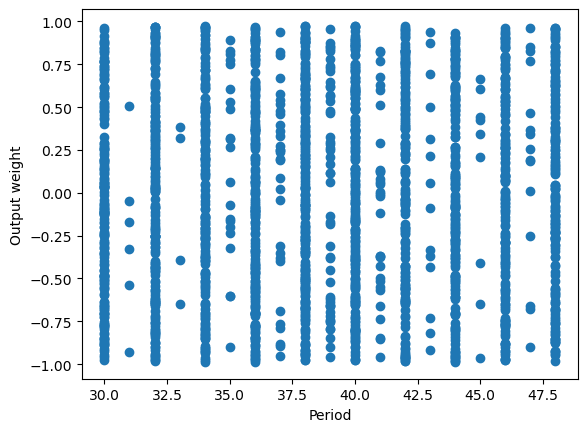

In [105]:
# plot init_output_weight_matrix against phases
plt.subplots()
plt.scatter(phases, init_output_weight_matrix.flatten())
plt.xlabel("Phase")
plt.ylabel("Output weight")

# plot init_output_weight_matrix against periods
plt.subplots()
plt.scatter(periods, init_output_weight_matrix.flatten())
plt.xlabel("Period")
plt.ylabel("Output weight")

### Hebbian learning with target

In [106]:
# calculate the desired output before the output sigmoid
gainout= 0.05 # 1.15
shiftout= 5 # -2.5
out_lr = 0.002
y_tildes = inv_sigmoid_np(targets) / gainout  + shiftout

In [107]:
# Simulate with control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
u = init_state.copy() * 0
this_output_weight_matrix = output_weight_matrix.copy()
xs_hebb, us_hebb, outputs_hebb_beforesig, outputs_hebb = [x], [], [], []
output_weights = [this_output_weight_matrix]
has_hebbian = False
adjust_out = False

# constants
hebbian_lr = 0.05
neg_punishment = 10
u_scale = 1

for t in time_points[:-1]:

    # jnn.i = t

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))

    # update readout weights by hebbian learning
    if not has_hebbian and t > 500:
        has_hebbian = True
        x_mean = np.concatenate(xs_hebb[stable_point:], axis=1).mean(axis=1).reshape(-1, 1)
        x_std = np.concatenate(xs_hebb[stable_point:], axis=1).std(axis=1).reshape(-1, 1)
        target_mean = 0.5
    
    # # start adjusting the output gains and shifts
    # if t > 2000:
    #     adjust_out = True
    #     has_hebbian = False
    #     period = 2 * half_period
    
    if has_hebbian:
        this_target = targets[t]
        # Calculate Hebbian weight updates
        hebbian_update = (this_target - target_mean) * ((x - x_mean) / x_std).T
        hebbian_update[np.logical_and(hebbian_update < 0, node_type == 1)] *= neg_punishment  # exh, punish <0
        hebbian_update[np.logical_and(hebbian_update > 0, node_type == -1)] *= neg_punishment  # inh, punish >0
        # hebbian_update = (output - output_mean) * ((x - x_mean) / x_std).T
        # hebbian_update = output * x.T
        # hebbian_update = hebbian_update * node_type
        # Normalized Hebbian learning
        tmp_output_weight_matrix = this_output_weight_matrix + hebbian_lr * hebbian_update
        tmp_ext = tmp_output_weight_matrix[:,node_type == 1]
        tmp_inh = tmp_output_weight_matrix[:,node_type == -1]
        tmp_ext[tmp_ext < 0] = 0
        tmp_inh[tmp_inh > 0] = 0
        tmp_ext /= np.sum(np.abs(tmp_ext)) / ext_weight_sum
        tmp_inh /= np.sum(np.abs(tmp_inh)) / inh_weight_sum
        tmp_output_weight_matrix[:,node_type == 1] = tmp_ext
        tmp_output_weight_matrix[:,node_type == -1] = tmp_inh
        # update init weights
        this_output_weight_matrix = tmp_output_weight_matrix.copy()
    
    # # adjust the gainout and shiftout
    # if adjust_out:
    #     mean_output = np.mean(outputs_hebb[t-period:t])
    #     amplitude = np.max(outputs_hebb[t-period:t]) - np.min(outputs_hebb[t-period:t])
    #     if np.abs(mean_output - 0.5) > 0.01:
    #         shiftout += out_lr * np.sign(mean_output - 0.5)
    #     if np.abs(amplitude - 0.5) > 0.01:
    #         gainout -= out_lr * np.sign(amplitude - 0.5)

    # input
    this_input = inputs[:,t]
    r = feedback_weight_matrix * this_input.reshape(-1,1)
    
    # if adjust_out:
    #     u_scale *= 0.99
    #     u = u_scale * u
    
    # update x
    x1 = jnn.f(x, u, r)
    # x1_0 = F @ x + G @ u + c
    # x1_1 = F_aug @ x_aug + G_aug @ u
    # print(np.linalg.norm(x1_0-x1))
    # print(np.linalg.norm(x1_1[0:num_nodes,:]-x1))
    x = x1.copy()
    
    # save
    xs_hebb.append(x)
    us_hebb.append(u)
    outputs_hebb_beforesig.append(output_beforesig.item())
    outputs_hebb.append(output.item())
    output_weights.append(this_output_weight_matrix)

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_hebb_beforesig.append(output_beforesig.item())
outputs_hebb.append(output.item())

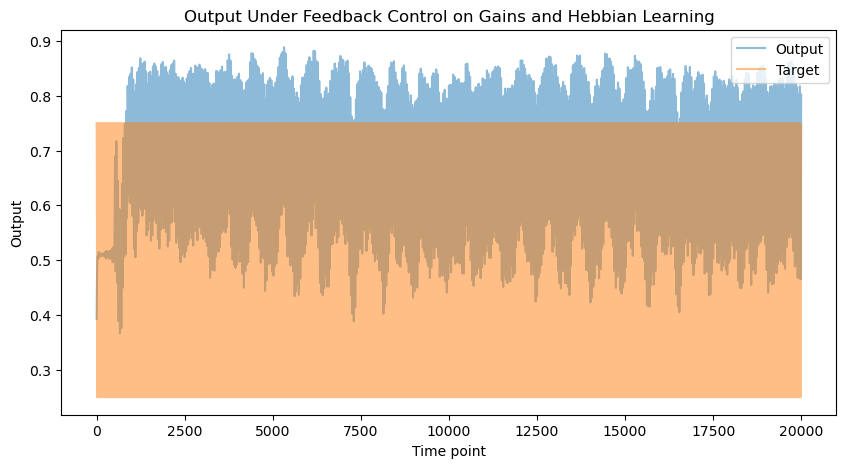

In [108]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_hebb, label='Output', alpha=0.5)
plt.plot(time_points, targets, label='Target', alpha=0.5)
plt.title('Output Under Feedback Control on Gains and Hebbian Learning')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
# if SAVEFIG:
#     plt.savefig("fig/FORCE_basis_hebb_output_0510.png")

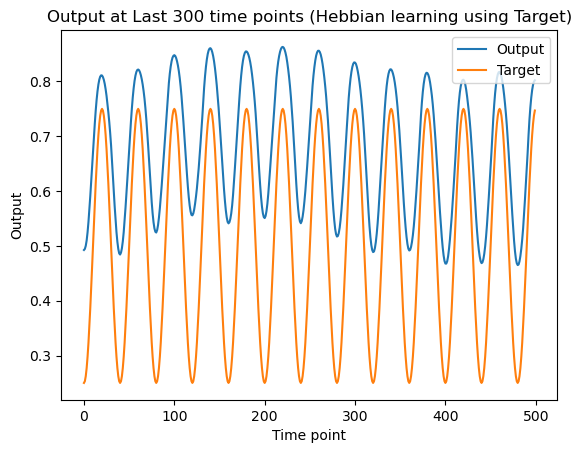

In [109]:
plt.plot(outputs_hebb[-500:], label='Output')
plt.plot(targets[-500:], label='Target')
plt.title('Output at Last 300 time points (Hebbian learning using Target)')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
# if SAVEFIG:
#     plt.savefig("fig/FORCE_wavebasis_outputhcp.png")

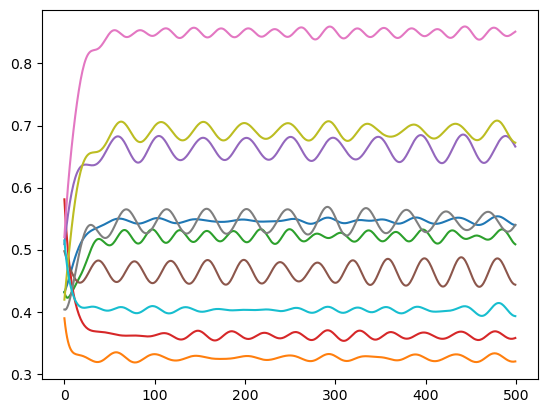

In [110]:
# same as ff_init!
all_xs_hebb = np.concatenate(xs_hebb, axis=1)
for i in range(0, 10):
    plt.plot(all_xs_hebb[i,0:500], label=f"Node {i}")

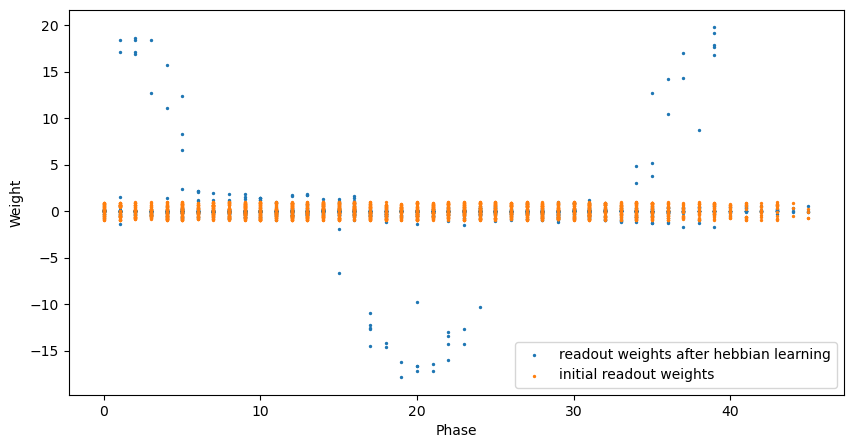

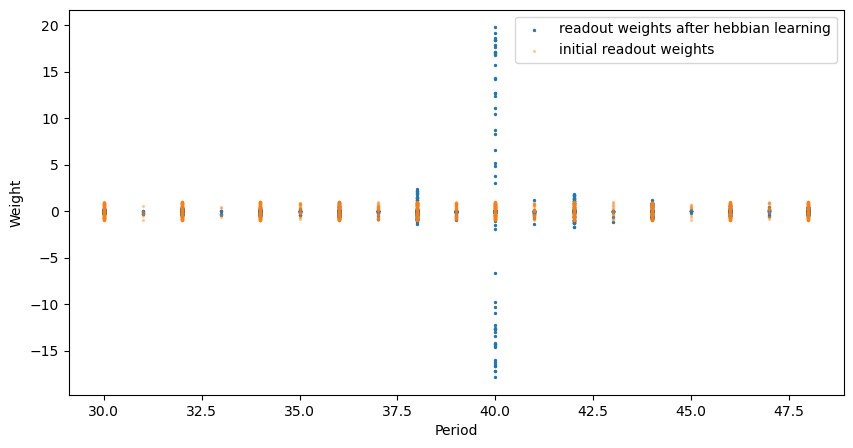

In [111]:
plt.subplots(figsize=(10, 5))
plt.scatter(phases, this_output_weight_matrix.flatten(), s=2, label="readout weights after hebbian learning")
plt.scatter(phases, init_output_weight_matrix.flatten(), s=2, label="initial readout weights")
plt.xlabel("Phase")
plt.ylabel("Weight")
plt.legend()
if SAVEFIG:
    plt.savefig(f"fig/FORCE_basis_hebb_weights_phase_0605_neg{neg_punishment}.png")

plt.subplots(figsize=(10, 5))
plt.scatter(periods, this_output_weight_matrix.flatten(), s=2, label="readout weights after hebbian learning")
plt.scatter(periods, init_output_weight_matrix.flatten(), s=2, label="initial readout weights", alpha=0.3)
plt.xlabel("Period")
plt.ylabel("Weight")
plt.legend()
if SAVEFIG:
    plt.savefig(f"fig/FORCE_basis_hebb_weights_period_0605_neg{neg_punishment}.png")

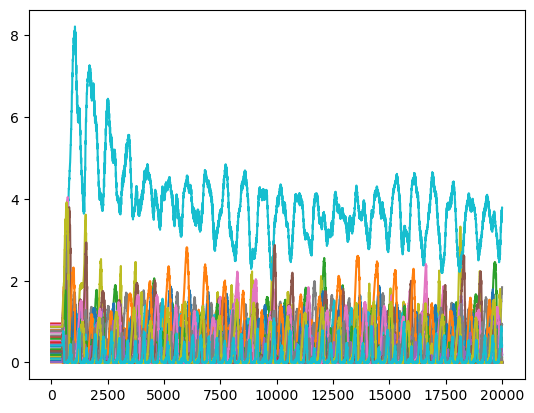

In [112]:
all_output_weights = np.concatenate(output_weights, axis=0).T
for i in range(50, 100):
    plt.plot(all_output_weights[i,:], label=f"Node {i}")

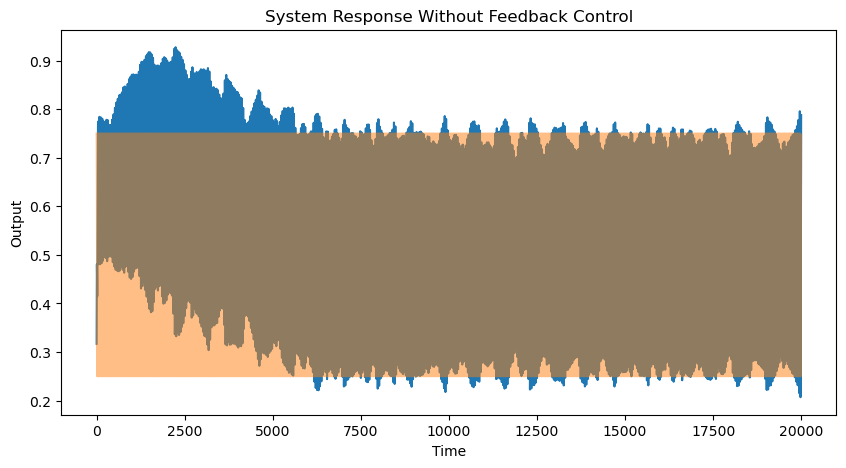

In [113]:
# Simulation Without Control
x = sigmoid_np(init_gain * (init_state.copy() - init_shift))
u = init_state.copy() * 0
xs, outputs_ff = [], []
gainouts, shiftouts = [], []

# constant
gainout = 0.05
shiftout = 5
half_period = 20
learn_output = True
n_period = 10
out_lr = 0.002  # 0.002

for i in time_points[:-1]:
    
    jnn_ff.i = i

    # output
    output_beforesig = this_output_weight_matrix @ x
    output = sigmoid_np(gainout * (output_beforesig - shiftout))  # previously wrong!
    # print(output_beforesig)

    # adjust the gainout and shiftout
    period = 2 * half_period
    if learn_output and n_period * period < i < 9000:
        # update shift
        mean_output = np.mean(outputs_ff[i-n_period*period:i])
        if np.abs(mean_output - 0.5) > 0.01:
            shiftout += out_lr * np.sign(mean_output - 0.5)
        # update gain
        if i % period == 0:
            amplitudes = []
            for j in range(n_period//10):
                amplitude = np.max(outputs_ff[i-(j+1)*period:i-j*period]) - np.min(outputs_ff[i-(j+1)*period:i-j*period])
                amplitudes.append(amplitude)
            mean_amplitude = np.mean(amplitudes)
            if np.abs(mean_amplitude - 0.5) > 0.01:
                gainout -= out_lr * np.sign(mean_amplitude - 0.5)
    
    gainouts.append(gainout)
    shiftouts.append(shiftout)

    # input
    this_input = inputs[:,i]
    r = feedback_weight_matrix * this_input.reshape(-1, 1)
    
    # update x
    x1 = jnn_ff.f(x, u, r)
    # x1 = jnn.f_linear(x, u, r)
    # F, G, R = jnn_ff.jacob(x, u, r)
    # x1 = F @ x + G @ u + R @ r
    x = x1.copy()

    # save
    xs.append(x)
    outputs_ff.append(output.item())

# final readout for x_T
output_beforesig = this_output_weight_matrix @ x
output = sigmoid_np(gainout * (output_beforesig - shiftout))
outputs_ff.append(output.item())

# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points, outputs_ff)
plt.plot(targets, alpha=0.5)
plt.xlabel('Time')
plt.ylabel('Output')
plt.title('System Response Without Feedback Control')
plt.show()

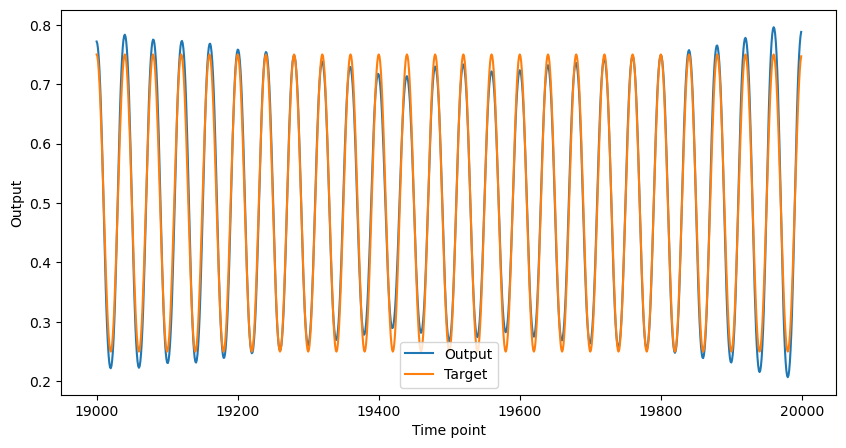

In [114]:
# Plot the output
fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(time_points[-1000:], outputs_ff[-1000:], label='Output')
plt.plot(time_points[-1000:], targets[-1000:], label='Target')
plt.xlabel('Time point')
plt.ylabel('Output')
plt.legend()
if SAVEFIG:
    plt.savefig(f"fig/FORCE_basis_output_0605_neg{neg_punishment}.png")

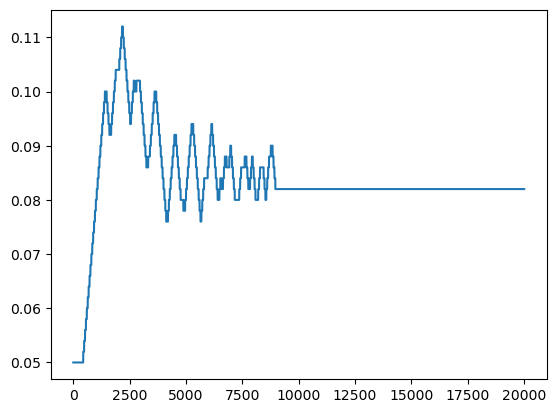

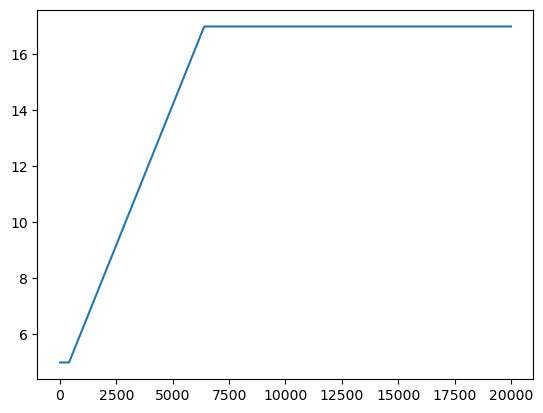

In [115]:
plt.plot(gainouts)
plt.show()

plt.plot(shiftouts)
plt.show()